In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv
/kaggle/input/customer-segmentation-clustering/customer_segmentation.csv


# *IMPORTING LIBRARIES*

In [2]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise_distances

# *LOADING DATA*

In [3]:
data = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# *DATA CLEANING*

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [6]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [7]:
# how many days each customer has been a customer 
#relative to the most recent customer's enrollment date.
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [8]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [9]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2025-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [10]:
data.describe()


,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,56.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,29.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,48.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,55.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,66.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,132.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

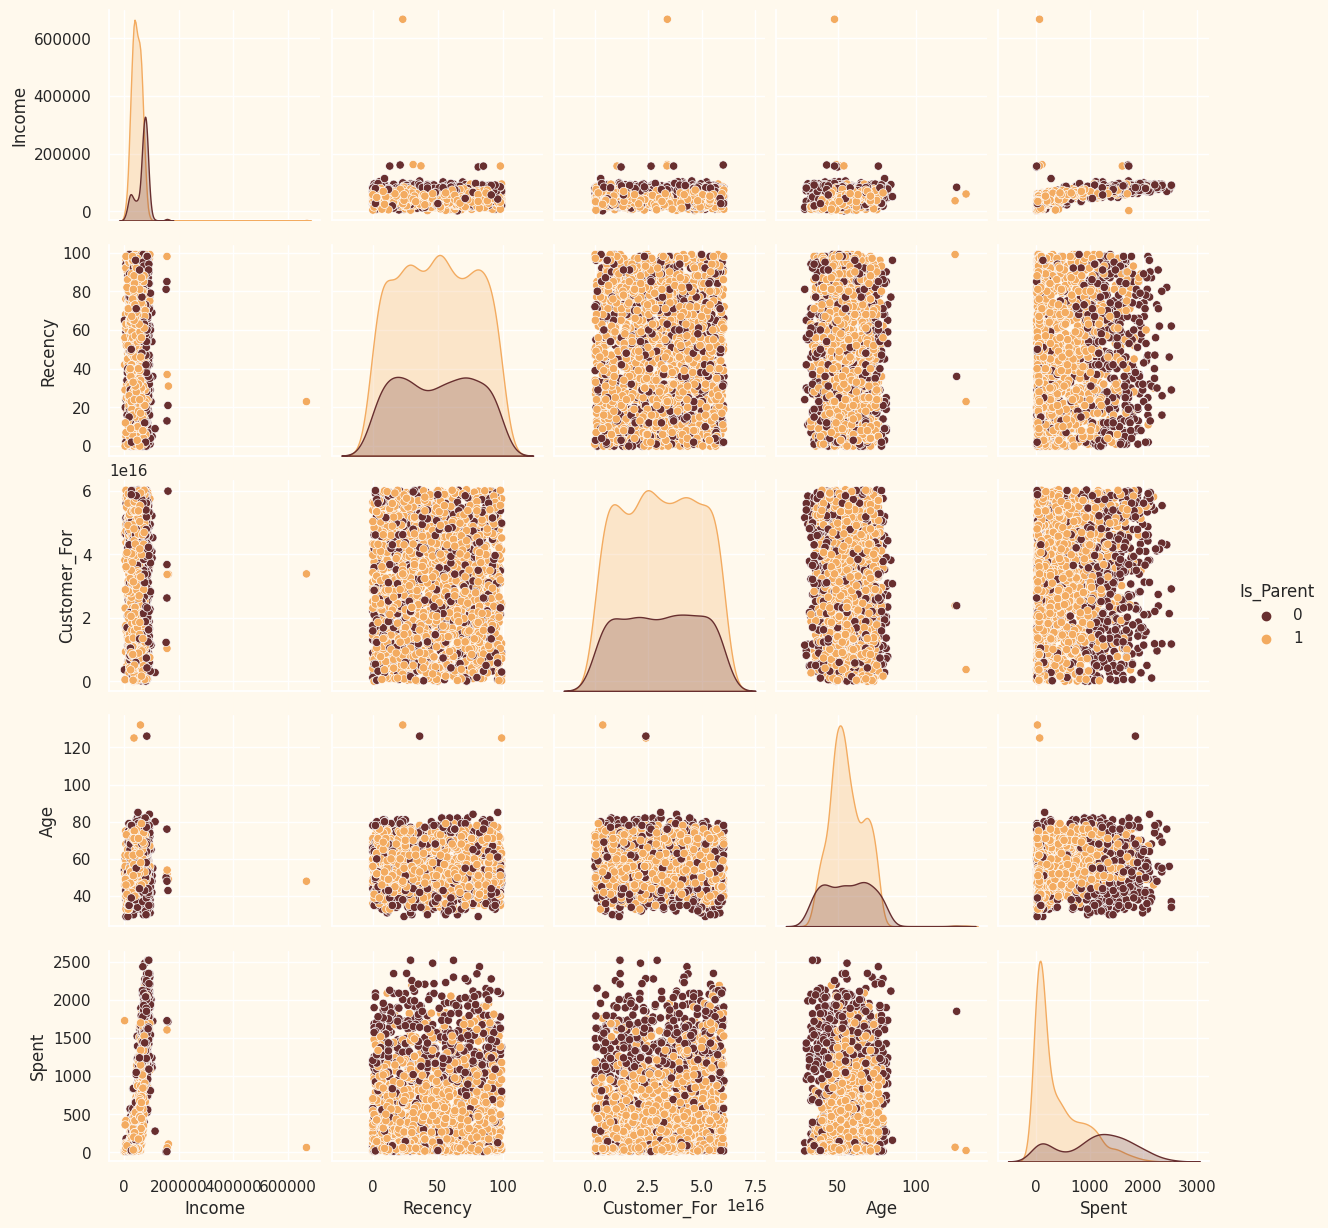

In [11]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [12]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


<Axes: >

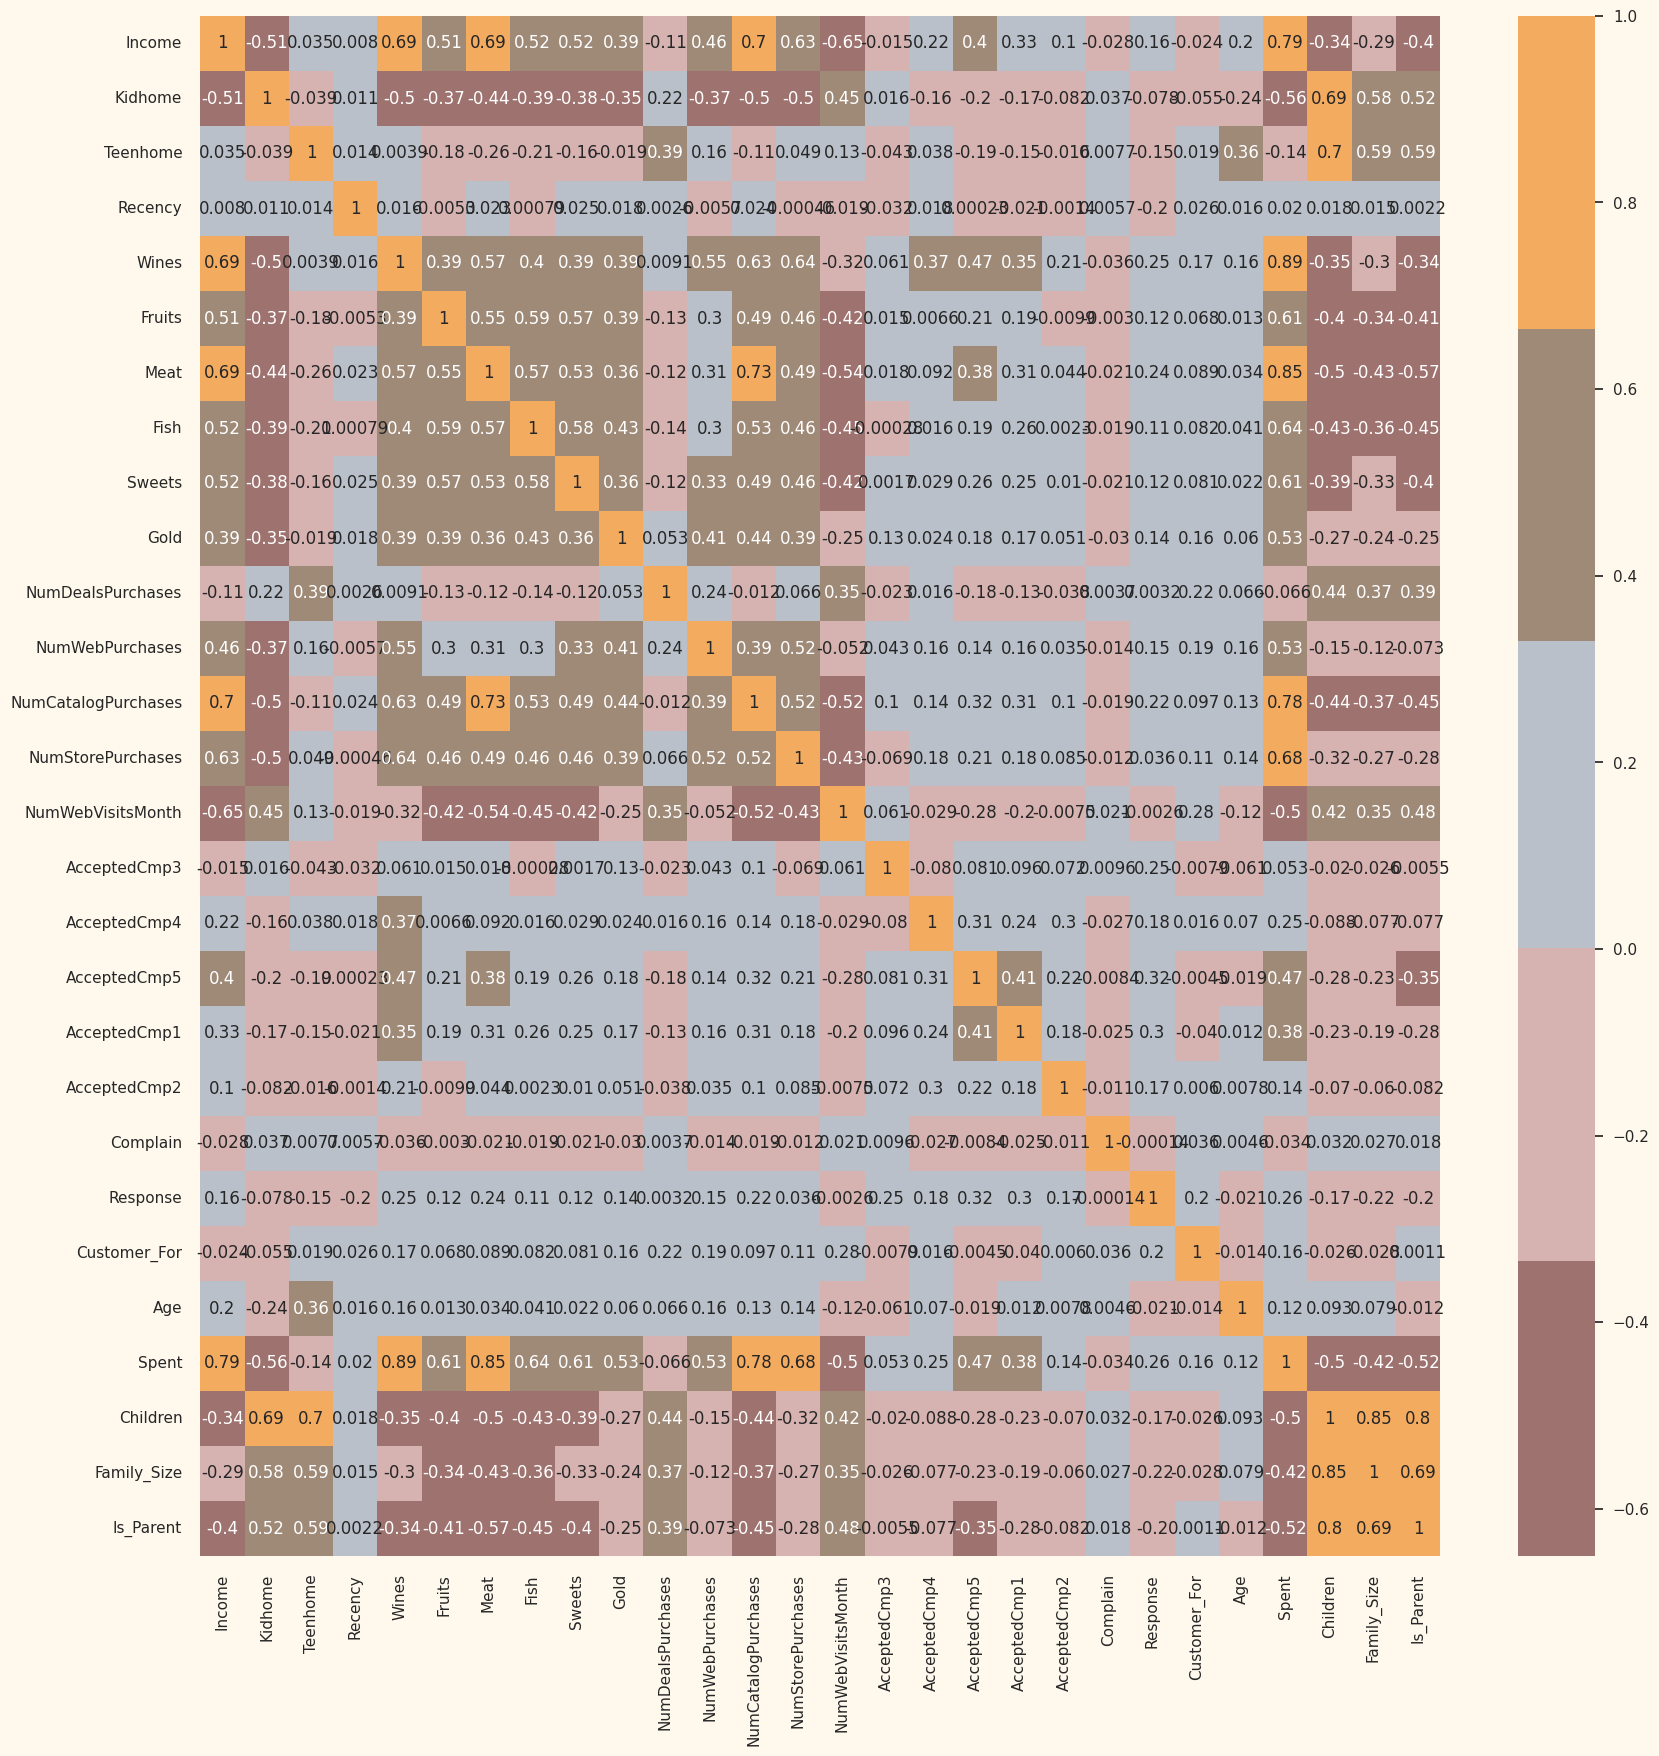

In [13]:
#correlation matrix
corrmat = data.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)

In [14]:
# Check for missing values
print(data.isnull().sum())



Education              0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
Wines                  0
Fruits                 0
Meat                   0
Fish                   0
Sweets                 0
Gold                   0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
Customer_For           0
Age                    0
Spent                  0
Living_With            0
Children               0
Family_Size            0
Is_Parent              0
dtype: int64


# *DATA PREPROCESSING*

In [15]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [16]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [17]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response','Kidhome', 'Teenhome', 'Is_Parent','Living_With','Education']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [18]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size
0,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.264598,-1.758359
1,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,1.404572,0.449070
2,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,-1.264598,-0.654644
3,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.069987,0.449070
4,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.069987,0.449070


# *DIMENSIONALITY REDUCTION*

In [19]:
X_scaled = scaled_ds.copy()   # Full scaled features

In [20]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(X_scaled)

PCA(n_components=3)

In [21]:
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-2.248553e-17,2.705212,-5.648014,-2.398294,-0.812656,2.357906,7.344110
col2,2212.0,2.890997e-17,1.453622,-3.596880,-1.069937,-0.189668,0.890911,6.145305
col3,2212.0,3.372829e-17,1.159007,-3.723350,-0.786679,-0.011252,0.778543,5.700317


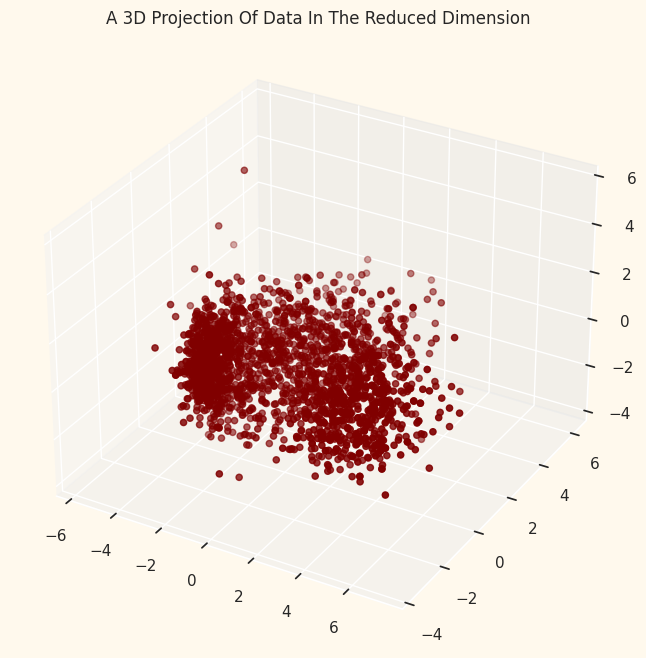

In [22]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Hybrid GA + KMeans Clustering

In [23]:
# 1. Import required libraries
import random
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from collections import Counter
from scipy.spatial.distance import pdist




In [24]:
# NUM_CLUSTERS = 5             # Number of clusters you want
# POPULATION_SIZE = 100                     # Number of individuals in population
# NUM_GENERATIONS = 500             # Number of generations
# MUTATION_RATE = 0.01              # Probability of mutation
# TOURNAMENT_SIZE = 5             # For tournament selection
# MIN_SAMPLES_PER_CLUSTER = 5  # Minimum points required per cluster# Configuration parameters                     
# ELITISM_RATE = 0.10                   # Percentage of elites to keep
# TOURNAMENT_SIZE_EARLY = 5             # Tournament size early generations
# TOURNAMENT_SIZE_LATE = 7              # Tournament size late generations
# LOCAL_SEARCH_FREQUENCY = 20           # Run local search every N generations
# DIVERSITY_CHECK_FREQUENCY = 25        # Check diversity every N generations
# NUM_CLUSTERS = 5             # Number of clusters you want
# POPULATION_SIZE = 200                     # Number of individuals in population
# NUM_GENERATIONS = 50           # Number of generations
MUTATION_RATE = 0.02              # Probability of mutation
TOURNAMENT_SIZE = 2             # For tournament selection
MIN_SAMPLES_PER_CLUSTER = 6  # Minimum points required per cluster# Configuration parameters                     
ELITISM_RATE = 0.2                   # Percentage of elites to keep
TOURNAMENT_SIZE_EARLY = 2             # Tournament size early generations
TOURNAMENT_SIZE_LATE = 4              # Tournament size late generations
LOCAL_SEARCH_FREQUENCY = 30           # Run local search every N generations
DIVERSITY_CHECK_FREQUENCY = 10        # Check diversity every N generations
max_generations=50
PENALTY_VALUE = 1000  # or any value that you want to use as a penalty
MAX_GENERATIONS = 50
NUM_CLUSTERS = 3
POPULATION_SIZE = 200
NUM_GENERATIONS = 50


In [25]:
# Fitness cache for memoization
fitness_cache = {}

In [26]:
X = scaled_ds.values


In [27]:
print(X)


[[ 0.28710487  0.31035323  0.97765966 ...  1.67624537 -1.26459792
  -1.75835869]
 [-0.26088203 -0.38081349 -0.87261799 ... -0.96329696  1.4045725
   0.44907004]
 [ 0.9131964  -0.79551352  0.35793525 ...  0.28011009 -1.26459792
  -0.65464433]
 ...
 [ 0.23334696  1.45077832  1.78715613 ...  1.05205171 -1.26459792
  -1.75835869]
 [ 0.80317156 -1.41756357  0.36386563 ...  0.39133608  0.06998729
   0.44907004]
 [ 0.04229031 -0.31169682 -0.65615923 ... -0.72258398  1.4045725
   1.55278441]]


In [28]:
#For demonstration, we'll create synthetic data
# X_scaled = StandardScaler().fit_transform(X)
np.random.seed(42)
NUM_FEATURES = X_scaled.shape[1] 
X = np.concatenate([
    np.random.normal(0, 1, (100, NUM_FEATURES)),
    np.random.normal(5, 1, (100, NUM_FEATURES)),
    np.random.normal(10, 1, (100, NUM_FEATURES))
])


In [29]:
print(X)


[[ 0.49671415 -0.1382643   0.64768854 ... -0.56228753 -1.01283112
   0.31424733]
 [-0.90802408 -1.4123037   1.46564877 ... -1.05771093  0.82254491
  -1.22084365]
 [ 0.2088636  -1.95967012 -1.32818605 ... -0.38508228 -0.676922
   0.61167629]
 ...
 [ 9.7251977   7.79875653  8.00111109 ... 10.11410149 10.06188335
   9.07244667]
 [ 9.80975916  8.50255333 11.36322898 ...  9.44286943  9.41358485
   9.38022787]
 [ 9.09123033 11.68452483 10.84229733 ... 10.73305428  8.10723782
  10.31149086]]


In [30]:
INDIVIDUAL_LENGTH = NUM_CLUSTERS * NUM_FEATURES

In [31]:
def create_individual(generation=0, max_generations=200):
    """Enhanced initialization combining K-Means++ and data-driven sampling"""
    # Method 1: K-Means++ initialization (70% probability in early generations)
    if generation < max_generations * 0.2 and random.random() < 0.7:
        indices = [np.random.choice(len(X))]
        for _ in range(1, NUM_CLUSTERS):
            dists = np.min(cdist(X, X[indices]), axis=1)
            probs = dists / (dists.sum() + 1e-8)  # Add small constant to avoid division by zero
            indices.append(np.random.choice(len(X), p=probs))
        return X[indices].flatten()
    
    # Method 2: Random data points with decreasing noise
    noise_scale = 0.5 if generation < max_generations * 0.5 else 0.1
    return (X[np.random.choice(len(X), NUM_CLUSTERS, replace=False)] + 
            np.random.normal(0, noise_scale, (NUM_CLUSTERS, NUM_FEATURES))).flatten()




In [32]:
def repair_individual(individual, X):
    """Ensure all clusters have at least MIN_SAMPLES_PER_CLUSTER points"""
    centroids = np.array(individual).reshape(NUM_CLUSTERS, NUM_FEATURES)
    distances = cdist(X, centroids, 'euclidean')
    labels = np.argmin(distances, axis=1)
    cluster_counts = np.bincount(labels, minlength=NUM_CLUSTERS)
    
    # Repair empty/small clusters
    for i in range(NUM_CLUSTERS):
        if cluster_counts[i] < MIN_SAMPLES_PER_CLUSTER:
            # Find the farthest point from all centroids in this cluster's region
            if cluster_counts[i] > 0:  # If cluster has some points
                cluster_points = X[labels == i]
                centroid_dist = cdist(cluster_points, [centroids[i]])
                farthest_idx = np.argmax(centroid_dist)
                centroids[i] = cluster_points[farthest_idx]
            else:  # For completely empty clusters
                centroids[i] = X[np.random.choice(len(X))].copy()
    
    return centroids.flatten()

In [33]:
def create_population(POPULATION_SIZE, generation=0, max_generations=200):
    """Create initial population with enhanced initialization"""
    # return  np.array([create_individual(generation, max_generations) for _ in range(POPULATION_SIZE)])##i think i have to kep it not comment but try
    return [repair_individual(create_individual(generation, max_generations) ,X) for _ in range(POPULATION_SIZE)]

In [34]:
def evaluate_fitness(individual, population=None, apply_sharing=False):
    global fitness_cache
    """Enhanced fitness evaluation with multiple criteria"""
    individual_tuple = tuple(individual)
    if individual_tuple in fitness_cache:
        return fitness_cache[individual_tuple]
    
    PENALTY_VALUE = 1000
    final_fitness = PENALTY_VALUE
    
    try:
        centroids = np.array(individual).reshape(NUM_CLUSTERS, NUM_FEATURES)
        distances = cdist(X, centroids, 'euclidean')
        labels = np.argmin(distances, axis=1).astype(int)
        
        # Cluster validity checks
        cluster_counts = np.bincount(labels, minlength=NUM_CLUSTERS)
        unique_clusters = np.unique(labels)
        
        if (len(unique_clusters) < 2 or 
            np.any(cluster_counts < MIN_SAMPLES_PER_CLUSTER)):
            return PENALTY_VALUE
        
        # Calculate metrics
        sil_score = silhouette_score(X, labels)
        intra_cluster = np.mean([np.mean(distances[labels == i, i]) 
                               for i in range(NUM_CLUSTERS) if cluster_counts[i] > 0])
        inter_cluster = np.min(pdist(centroids))if NUM_CLUSTERS > 1 else 0
        balance_penalty = np.std(cluster_counts) / len(X)
        
        # Optimized weight distribution
        base_fitness = - (0.85 * sil_score + 
                         0.10 * (1/intra_cluster) + 
                         0.05 * inter_cluster - 
                         0.02 * balance_penalty - 
                         0.05 * (NUM_CLUSTERS - len(unique_clusters)))
        
        # Fitness sharing if enabled
        if apply_sharing and population is not None:
            sigma_share = 0.3 * NUM_FEATURES
            alpha = 1
            share_sum = 1.0
            
            for other in random.sample(population, min(20, len(population))):
                distance = np.linalg.norm(np.array(individual) - np.array(other))
                if distance < sigma_share:
                    share_sum += 1 - (distance/sigma_share)**alpha
            
            final_fitness = base_fitness / share_sum
        else:
            final_fitness = base_fitness
            
    except Exception as e:
        print(f"Error in fitness evaluation: {str(e)}")
        final_fitness = PENALTY_VALUE
    
    fitness_cache[individual_tuple] = final_fitness
    return final_fitness

In [35]:
def tournament_selection(population, fitnesses, generation, max_generations, tournament_size=3, elitism=0.15):
    # Gradually increase tournament size
    min_size = 3
    max_size = 7
    diversity = np.mean(pairwise_distances(population))
    tournament_size = min_size + int((generation/max_generations) * (max_size-min_size))
    
    # Keep some randomness in selection pressure
    if random.random() < 0.2:  # 20% chance to vary
        tournament_size = random.randint(min_size, max_size)
        
    selected = []
    elite_count = int(ELITISM_RATE * len(population))
    
    # Elitism: select top elite_count individuals
    if elite_count > 0:
        elite_indices = np.argpartition(fitnesses, elite_count)[:elite_count]
        elites = [population[i] for i in elite_indices]
        selected.extend(elites)
    
    # Tournament selection for the rest
    for _ in range(len(population) - elite_count):
        participants = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = min(participants, key=lambda x: x[1])  # Assuming minimization
        selected.append(winner[0])
    
    return selected



In [36]:
def crossover(parent1, parent2, generation, max_generations):
    """SBX crossover returning both children"""
    crossover_rate = 0.9 - (0.5 * generation/max_generations)
    if random.random() > crossover_rate:
        return parent1.copy(), parent2.copy()
    
    p1 = np.array(parent1).reshape(NUM_CLUSTERS, NUM_FEATURES)
    p2 = np.array(parent2).reshape(NUM_CLUSTERS, NUM_FEATURES)
    
    child1 = np.zeros_like(p1)
    child2 = np.zeros_like(p1)
    eta = random.uniform(2, 10)

    for k in range(NUM_CLUSTERS):
        for d in range(NUM_FEATURES):
            u = random.random()
            beta = (2*u)**(1/(eta+1)) if u <= 0.5 else (1/(2*(1-u)))**(1/(eta+1))
            child1[k,d] = 0.5*((1+beta)*p1[k,d] + (1-beta)*p2[k,d])
            child2[k,d] = 0.5*((1-beta)*p1[k,d] + (1+beta)*p2[k,d])

    child1 = np.clip(child1, X.min(axis=0), X.max(axis=0)).flatten()
    child2 = np.clip(child2, X.min(axis=0), X.max(axis=0)).flatten()
    
    return child1, child2

In [37]:

def mutate(individual, generation, max_generations):
    
    individual = np.array(individual).reshape(NUM_CLUSTERS, NUM_FEATURES)##aff reshape
    
    # base_rate = 0.2 if generation < max_generations*0.3 else 0.1
    # mutation_rate = base_rate + (0.3 * (1 - generation/max_generations))
    mutation_rate = 0.1 + (0.3 * (1 - (generation / max_generations)))  # Starts at 0.4, decays to 0.1

    # Adaptive mutation parameters
    mutation_strength = 0.5 * (1 - generation/max_generations)  # Decreases over time
    mutation_prob = 0.3 * (1 + generation/max_generations)     # Increases slightly

    # Occasionally do large mutations
    if random.random() < 0.1:  # 10% chance for big mutation
        mutation_rate = min(0.5, mutation_rate * 3)
    
    for i in range(len(individual)):
        if random.random() < mutation_prob:##here was mutation rate:
            step_size = max(0.2 * (1 - generation / max_generations), 1e-6)
            individual[i] += np.random.normal(0, step_size)
    
    # --- Reflection Boundary Handling ---
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)
    for i in range(NUM_CLUSTERS):
        for j in range(NUM_FEATURES):
            if individual[i, j] < min_vals[j]:
                individual[i, j] = min_vals[j] + (min_vals[j] - individual[i, j])
            elif individual[i, j] > max_vals[j]:
                individual[i, j] = max_vals[j] - (individual[i, j] - max_vals[j])

    # --- K-Means Local Refinement (1 iteration) ---
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, init=individual, n_init=1, max_iter=1)
    kmeans.fit(X)
    refined_centroids = kmeans.cluster_centers_

    return refined_centroids.flatten()


In [38]:
def local_search_kmeans(individual, X, n_features, fitnesses, max_iter=10):
    """Refine centroids using KMeans with warm-start from individual."""
    n_features = X.shape[1]
    centroids = individual.reshape(NUM_CLUSTERS, NUM_FEATURES)

    try:
        kmeans = KMeans(
            n_clusters=NUM_CLUSTERS,
            init=centroids,
            n_init=1,
            max_iter=max_iter,
            random_state=42
        )
        kmeans.fit(X)
        refined = kmeans.cluster_centers_.flatten()

        #Track improvement
        before = fitnesses(individual)
        after = fitnesses(refined)
        print(f"[LocalSearch] Improved fitness: {before:.4f} -> {after:.4f}")
        
        return refined
    except Exception as e:
        print(f"[WARN] Local search failed: {e}")
        return individual  # fallback in case KMeans fails



Population size: 200, Fitnesses size: 200
Gen 1: Valid 200/200 | Best 1.7851 | Avg 1.1571 
[LocalSearch] Improved fitness: -1.6928 -> -1.6928
Gen 2: Valid 200/200 | Best 1.7971 | Avg 1.6714 
Gen 3: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 4: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 5: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 6: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 7: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 8: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 9: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 10: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 11: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 12: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 13: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 14: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 15: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 16: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 17: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 18: Valid 200/200 | Best 1.6928 | Avg 1.6928 
Gen 19: Valid 20

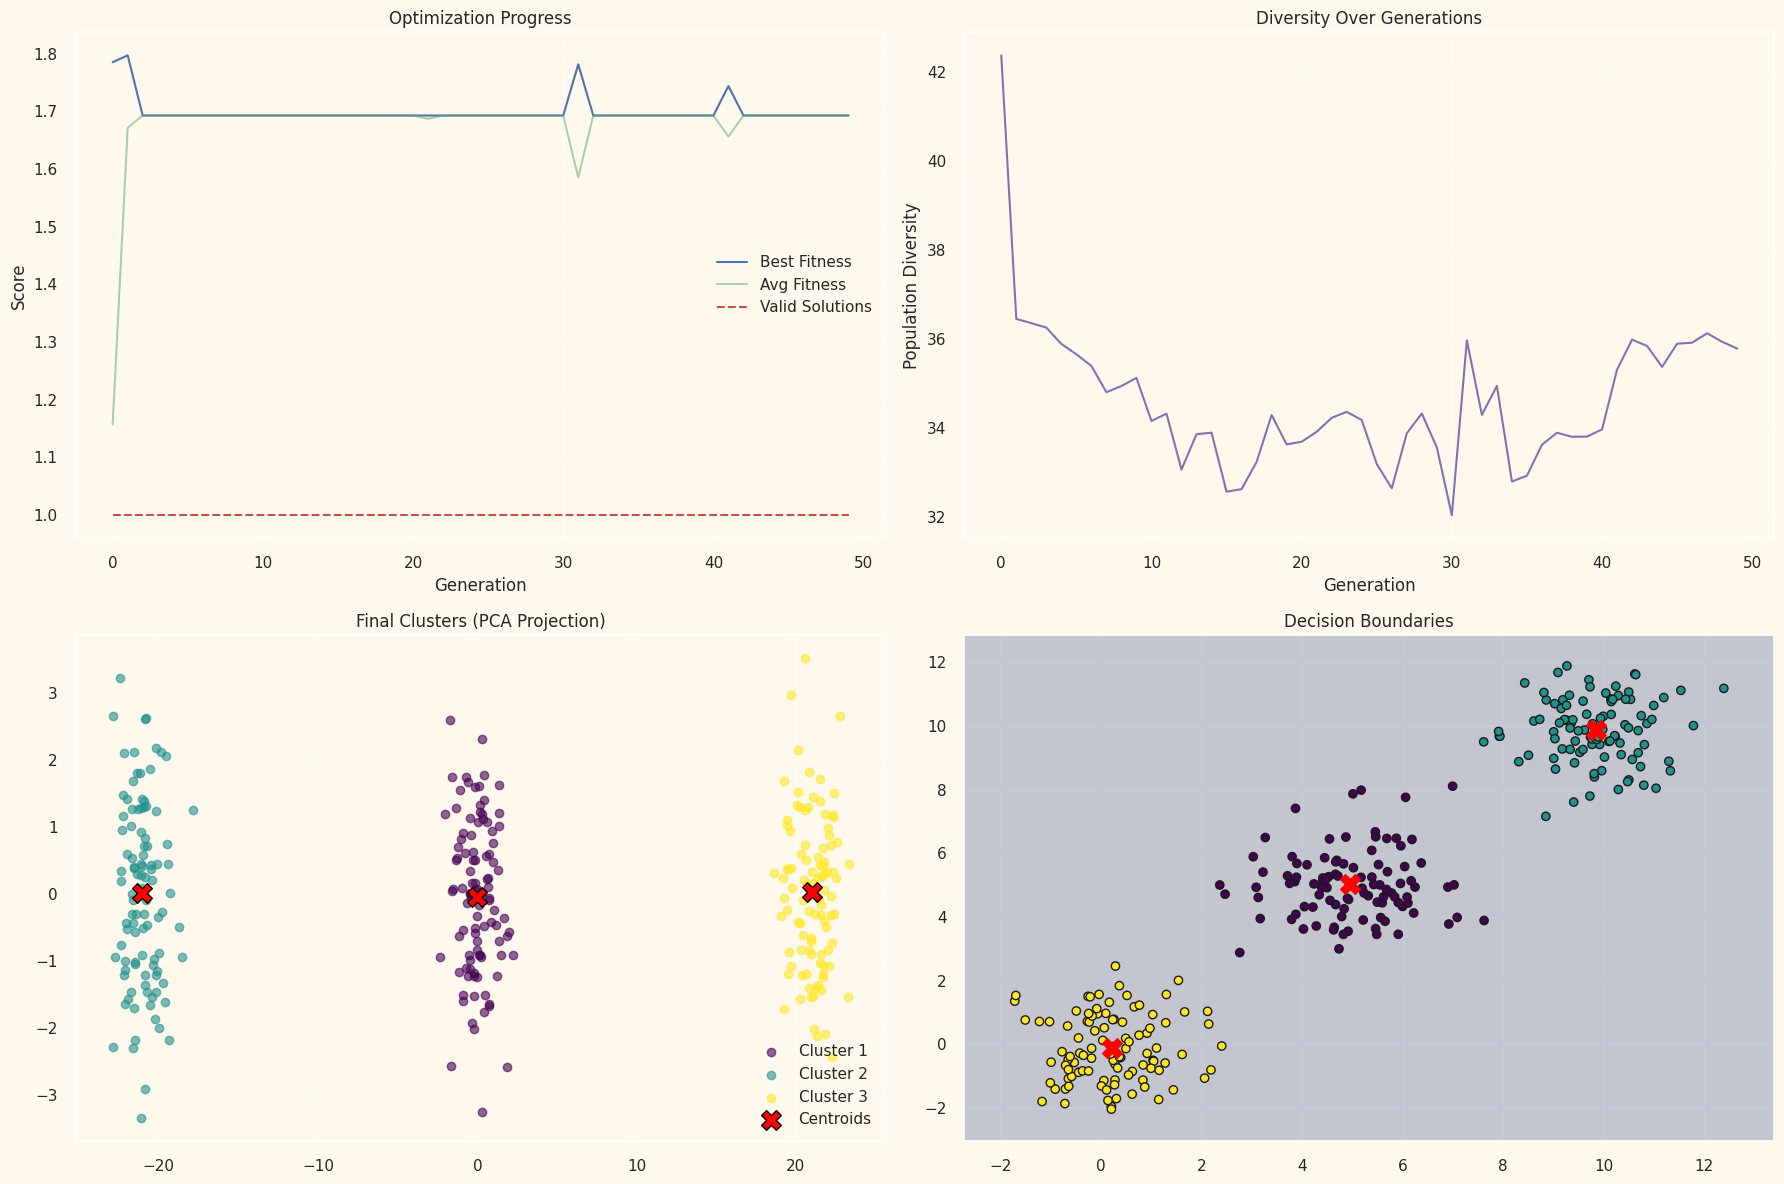


Best clustering score: 1.6928
Final centroids:
 [[ 4.96324656e+00  5.02065979e+00  5.08076683e+00  5.02707885e+00
   4.91461536e+00  5.07591813e+00  5.04951267e+00  5.12366669e+00
   4.88241879e+00  4.85942343e+00  5.06600314e+00  5.07247448e+00
   4.97246652e+00  5.00456744e+00  5.00231623e+00  4.77424979e+00
   4.94577929e+00  5.25820509e+00]
 [ 9.83722086e+00  9.86632372e+00  1.00908823e+01  9.91684542e+00
   9.79613872e+00  9.98352265e+00  9.99509122e+00  9.96285958e+00
   1.00122276e+01  9.95225044e+00  1.01332079e+01  9.94782925e+00
   9.85767901e+00  9.97306784e+00  9.99094407e+00  9.91364065e+00
   9.92369197e+00  1.00795841e+01]
 [ 2.17043828e-01 -1.13529423e-01 -9.72502455e-02  8.26768468e-03
  -1.79668273e-02 -5.45881199e-02  1.16952220e-01 -3.70356199e-02
  -5.36466708e-02  1.15471626e-01 -1.13484781e-01  2.37625921e-01
   1.43710068e-01  7.49240341e-02  1.46162274e-01  1.26330707e-01
   2.46311783e-02  1.40594472e-01]]


In [39]:
def run_genetic_algorithm():
    # Initialize population and tracking variables
    # population = create_population(POPULATION_SIZE)
    population = [repair_individual(ind, X) for ind in create_population(POPULATION_SIZE)]  # Apply repair during initialization
    best_fitness_history = []
    avg_fitness_history = []
    valid_solutions_history = []
    diversity_history = []

    

    # Initialize fitnesses as a list of fitness values
    fitnesses = [evaluate_fitness(ind) for ind in population]

    print(f"Population size: {len(population)}, Fitnesses size: {len(fitnesses)}")

    for generation in range(max_generations):
        # Adaptive fitness evaluation
        apply_sharing = (generation < max_generations//2) and (generation % 5 == 0)##generation < NUM_GENERATIONS//2 thw change 
        fitnesses = [evaluate_fitness(ind, 
                      population if apply_sharing else None, 
                      apply_sharing) 
                    for ind in population]
        # fitnesses = [evaluate_fitness(individual) for individual in population]
        
        # Process fitness values
        valid_fitnesses = [f for f in fitnesses if f < PENALTY_VALUE]
        valid_count = len(valid_fitnesses)
        best_fit = min(valid_fitnesses) if valid_fitnesses else PENALTY_VALUE
        avg_fit = np.mean(valid_fitnesses) if valid_fitnesses else PENALTY_VALUE
        
        # Track metrics
        best_fitness_history.append(best_fit)
        avg_fitness_history.append(avg_fit)
        valid_solutions_history.append(valid_count)
        

        
        
        # Calculate diversity (moved before selection)
        diversity_history.append(np.mean(pdist(population)))

        
        print(f"Gen {generation+1}: Valid {valid_count}/{len(population)} | Best {-best_fit:.4f} | Avg {-avg_fit:.4f} ")
        
        # Tournament selection
        selected = []
        for _ in range(POPULATION_SIZE):
            candidates = random.sample(range (POPULATION_SIZE), min(5, (POPULATION_SIZE)//2))
            # Select the individual with the best (smallest) fitness
            best_candidate_idx = min(candidates, key=lambda x: fitnesses[x])
            selected.append(population[best_candidate_idx])
            # selected.append(population[min(candidates, key=lambda x: fitnesses[x])])
        
        # Reproduction
        next_gen = []
        for i in range(0, len(selected) - 1, 2):
            p1, p2 = selected[i], selected[i+1]
            c1, c2 = crossover(p1, p2, generation, MAX_GENERATIONS)
            c1 = mutate(c1, generation, MAX_GENERATIONS)
            c2 = mutate(c2, generation, MAX_GENERATIONS)
            next_gen.extend([
                repair_individual(c1,X),
                repair_individual(c2 ,X)
            ])
        
        population = next_gen[:POPULATION_SIZE]

        
        # Diversity maintenance
        if generation % DIVERSITY_CHECK_FREQUENCY == 0:
            pop_array = np.array(population)
            kmeans = KMeans(n_clusters=min(5, len(population)//2)).fit(pop_array)
            cluster_counts = Counter(kmeans.labels_)
            
            for cluster_idx, count in cluster_counts.items():
                if count > len(population)//3:
                    to_replace = count - len(population)//3
                    cluster_indices = np.where(kmeans.labels_ == cluster_idx)[0]
                    replace_indices = np.random.choice(cluster_indices, to_replace, replace=False)
                    for idx in replace_indices:
                        population[idx] = create_individual(generation, NUM_GENERATIONS)

        # fitnesses = evaluate_fitness
        # Local search intensification
        if generation % LOCAL_SEARCH_FREQUENCY == 0:
            best_idx = np.argmin(fitnesses)##fitnesses
            # population[best_idx] = local_search(population[best_idx])
            population[best_idx] = local_search_kmeans(population[best_idx], X, NUM_CLUSTERS, evaluate_fitness)
            fitnesses[best_idx] = evaluate_fitness(population[best_idx], population, apply_sharing)
            

            # Update fitness values after population modification
            fitnesses = [evaluate_fitness(ind, population) for ind in population]

            
            # Replace worst individuals
            worst_indices = np.argsort(fitnesses)[-len(population)//20:]
            for idx in worst_indices:
                population[idx] = create_individual(generation, NUM_GENERATIONS)
                fitnesses[idx] = evaluate_fitness(population[idx], population, apply_sharing)  # Recalculate fitness for replaced individuals


        # Restart mechanism
        if generation == 50 and len(best_fitness_history) > 50:
            if (best_fitness_history[49] - best_fitness_history[0]) < 0.05:
                print("Restarting population for better exploration")
                elite_count = int(POPULATION_SIZE * 0.1)
                elite_indices = np.argpartition(fitnesses, elite_count)[:elite_count]
                elites = [population[i] for i in elite_indices]
                population = elites + create_population(POPULATION_SIZE - elite_count, generation, NUM_GENERATIONS)
                # Clear fitness cache after population restart
                fitness_cache.clear()

    # Final evaluation
    best_idx = np.argmin([evaluate_fitness(ind) for ind in population])
    best_individual = population[best_idx]
    best_centroids = np.array(best_individual).reshape(NUM_CLUSTERS, NUM_FEATURES)
    best_score = -min([evaluate_fitness(ind) for ind in population])  # Positive score

    # Visualization
    visualize_results(X, best_centroids, best_fitness_history, 
                    avg_fitness_history, valid_solutions_history, 
                    diversity_history, NUM_CLUSTERS, POPULATION_SIZE)
    
    return best_centroids, best_score

def visualize_results(X, centroids, best_fitness, avg_fitness, 
                    valid_solutions, diversity, n_clusters, pop_size):
    """Consolidated visualization function"""
    plt.figure(figsize=(18, 12))
    
    # 1. Optimization Progress
    plt.subplot(2, 2, 1)
    plt.plot([-f for f in best_fitness], 'b-', label='Best Fitness')
    plt.plot([-f for f in avg_fitness], 'g-', alpha=0.5, label='Avg Fitness')
    plt.plot([v/pop_size for v in valid_solutions], 'r--', label='Valid Solutions')
    plt.xlabel('Generation')
    plt.ylabel('Score')
    plt.title('Optimization Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Diversity Tracking
    plt.subplot(2, 2, 2)
    plt.plot(diversity, 'm-')
    plt.xlabel('Generation')
    plt.ylabel('Population Diversity')
    plt.title('Diversity Over Generations')
    plt.grid(True, alpha=0.3)

    # 3. PCA Projection
    plt.subplot(2, 2, 3)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    centroids_pca = pca.transform(centroids)
    
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    labels = np.argmin(cdist(X, centroids), axis=1)
    
    for k in range(n_clusters):
        plt.scatter(X_pca[labels == k, 0], X_pca[labels == k, 1],
                    c=[colors[k]], alpha=0.6, label=f'Cluster {k+1}')

    plt.scatter(centroids_pca[:,0], centroids_pca[:,1],
                c='red', marker='X', s=200, edgecolor='black',
                linewidth=1, label='Centroids')
    plt.title('Final Clusters (PCA Projection)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Decision Boundaries
    plt.subplot(2, 2, 4)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    if X.shape[1] > 2:
        mesh_points = np.hstack([mesh_points, np.zeros((mesh_points.shape[0], X.shape[1]-2))])
    
    Z = np.argmin(cdist(mesh_points, centroids), axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='k')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)
    plt.title('Decision Boundaries')
    
    plt.tight_layout()
    plt.show()

# Run the algorithm
best_centroids, best_score = run_genetic_algorithm()
print(f"\nBest clustering score: {best_score:.4f}")
print("Final centroids:\n", best_centroids)

# *EVALUATING MODELS*

In [40]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# After getting your final clusters
labels = np.argmin(cdist(X, best_centroids), axis=1)

# Silhouette Score (-1 to 1, higher is better)
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Davies-Bouldin Index (0 to ∞, lower is better)
db_index = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Calinski-Harabasz Index (higher is better)
ch_index = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

Silhouette Score: 0.7269
Davies-Bouldin Index: 0.3949
Calinski-Harabasz Index: 2483.7872


In [41]:
from sklearn.cluster import KMeans, DBSCAN

# Compare with KMeans
kmeans = KMeans(n_clusters=NUM_CLUSTERS).fit(X)
print("KMeans Silhouette:", silhouette_score(X, kmeans.labels_))

# Compare with DBSCAN (if appropriate for your data)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X)
if len(np.unique(dbscan.labels_)) > 1:
    print("DBSCAN Silhouette:", silhouette_score(X, dbscan.labels_))

KMeans Silhouette: 0.72690018547111


In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def evaluate_silhouette(X, labels):
    score = silhouette_score(X, labels)
    print(f"Silhouette Score: {score:.4f}")
    return score



# Fit KMeans to the data
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans.fit(X)

# Print Silhouette Score
evaluate_silhouette(X, kmeans.labels_)


Silhouette Score: 0.7269


0.72690018547111

In [43]:
import joblib

def save_model(model, filename='best_centroids.pkl'):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")
